In [2]:
import shutil
#shutil.copy('/content/main/Sentiment_LSTM_model.h5','/content/drive/MyDrive/Sentiment_LSTM_model.h5')
#shutil.copy('/content/main/trainHistoryDict','/content/drive/MyDrive/trainHistoryDict')
#shutil.copy('/content/main/trainHistoryDict','/content/drive/MyDrive/trainHistoryDict')

shutil.copy('/content/drive/MyDrive/sentiment140.csv','/content/sentiment140.csv')
#shutil.copy('/content/main/trainHistoryDict','/content/drive/MyDrive/trainHistoryDict')
#shutil.copy('/content/main/trainHistoryDict','/content/drive/MyDrive/trainHistoryDict')


'/content/sentiment140.csv'

In [3]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('sentiment140.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
data.head()
X = data.iloc[:,[5]]
Y = data.iloc[:,0]
Y[Y == 4] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [5]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Text-preprocessing

# Missing Values
num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions
print('Number of missing values: ' + str(num_missing_desc))
data = data.dropna()

TAG_CLEANING_RE = "@\S+"
# Remove @tags
X['text'] = X['text'].map(lambda x: re.sub(TAG_CLEANING_RE, ' ', x))

# Smart lowercase
X['text'] = X['text'].map(lambda x: x.lower())

# Remove numbers
X['text'] = X['text'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove links
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['text'] = X['text'].map(lambda x: re.sub(TEXT_CLEANING_RE, ' ', x))

# Remove Punctuation
X['text']  = X['text'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
X['text'] = X['text'].map(lambda x: x.strip())

# Tokenize into words
X['text'] = X['text'].map(lambda x: word_tokenize(x))
 
# Remove non alphabetic tokens
X['text'] = X['text'].map(lambda x: [word for word in x if word.isalpha()])

# Filter out stop words
stop_words = set(stopwords.words('english'))
X['text'] = X['text'].map(lambda x: [w for w in x if not w in stop_words])
    
# Word Lemmatization
lem = WordNetLemmatizer()
X['text'] = X['text'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
X['text'] = X['text'].map(lambda x: ' '.join(x))

Number of missing values: 0


In [7]:
X.head()

,text
0,zl awww bummer shoulda get david carr third day
1,upset update facebook texting might cry result...
2,dive many time ball manage save rest go bound
3,whole body feel itchy like fire
4,behave mad see


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_train))

TRAIN size: 1280000
TEST size: 1280000


## Flow 

- Pre-processing
- create word2vec
- tokenize and padding
- model creation
- testing

In [10]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in X_train.text] 
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)

In [11]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 25276


In [12]:
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(251365822, 289225504)

In [14]:
#Test word embeddings
w2v_model.most_similar("good")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('great', 0.6926903128623962),
 ('bad', 0.5545793771743774),
 ('goood', 0.5121532678604126),
 ('rough', 0.4977189898490906),
 ('gooood', 0.4802212119102478),
 ('nice', 0.47655367851257324),
 ('wonderful', 0.4735257029533386),
 ('fantastic', 0.45791926980018616),
 ('goooooood', 0.4489831030368805),
 ('terrible', 0.43800589442253113)]

In [15]:
# Tokenizing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train.text)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Found 232838 unique tokens.
Shape of data tensor: (1280000, 300)


In [17]:
# saving
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(232839, 300)


In [19]:
# Build Model
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          69851700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 70,012,201
Trainable params: 160,501
Non-trainable params: 69,851,700
_________________________________________________________________


In [20]:
# Training 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train,
                    batch_size=512,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)
model.save('main/Sentiment_LSTM_model.h5')
with open('main/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Epoch 1/5
2250/2250 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.7507 - f1_m: 0.7515 - precision_m: 0.7477 - recall_m: 0.7563

2250/2250 [==============================] - 1183s 523ms/step - loss: 0.5027 - accuracy: 0.7507 - f1_m: 0.7515 - precision_m: 0.7477 - recall_m: 0.7563 - val_loss: 0.4679 - val_accuracy: 0.7756 - val_f1_m: 0.7753 - val_precision_m: 0.7750 - val_recall_m: 0.7762 - lr: 0.0010
Epoch 2/5
2250/2250 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.7648 - f1_m: 0.7659 - precision_m: 0.7609 - recall_m: 0.7720

2250/2250 [==============================] - 1166s 518ms/step - loss: 0.4819 - accuracy: 0.7648 - f1_m: 0.7659 - precision_m: 0.7609 - recall_m: 0.7720 - val_loss: 0.4651 - val_accuracy: 0.7791 - val_f1_m: 0.7787 - val_precision_m: 0.7788 - val_recall_m: 0.7793 - lr: 0.0010
Epoch 3/5
2250/2250 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.7687 - f1_m: 0.7699 - precision_m: 0.7647 - recall_m: 0.7760

2250/2250 [==============================] - 1162s 517ms/step - loss: 0.4766 - accuracy: 0.7687 - f1_m: 0.7699 - precision_m: 0.7647 - recall_m: 0.7760 - val_loss: 0.4609 - val_accuracy: 0.7823 - val_f1_m: 0.7836 - val_precision_m: 0.7778 - val_recall_m: 0.7902 - lr: 0.0010
Epoch 4/5
2250/2250 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.7680 - f1_m: 0.7686 - precision_m: 0.7643 - recall_m: 0.7749

2250/2250 [==============================] - 1162s 516ms/step - loss: 0.4778 - accuracy: 0.7680 - f1_m: 0.7686 - precision_m: 0.7643 - recall_m: 0.7749 - val_loss: 0.4621 - val_accuracy: 0.7804 - val_f1_m: 0.7764 - val_precision_m: 0.7896 - val_recall_m: 0.7644 - lr: 0.0010
Epoch 5/5
2250/2250 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7703 - f1_m: 0.7714 - precision_m: 0.7662 - recall_m: 0.7776

2250/2250 [==============================] - 1159s 515ms/step - loss: 0.4743 - accuracy: 0.7703 - f1_m: 0.7714 - precision_m: 0.7662 - recall_m: 0.7776 - val_loss: 0.4592 - val_accuracy: 0.7822 - val_f1_m: 0.7846 - val_precision_m: 0.7749 - val_recall_m: 0.7952 - lr: 0.0010


In [30]:
# Load Model
from keras.models import load_model
#model = load_model('main/Sentiment_LSTM_model.h5', custom_objects=list(f1_m, precision_m, recall_m))
# loading tokenizer
with open('main/trainHistoryDict', 'rb') as file_pi:
    history = pickle.load(file_pi)

In [28]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)

625/625 [==============================] - 68s 109ms/step - loss: 0.4563 - accuracy: 0.7840 - f1_m: 0.7869 - precision_m: 0.7780 - recall_m: 0.7968


LOSS: 0.4562610983848572
ACCURACY: 0.783984363079071
F1 SCORE: 0.7869452834129333
PRECISION: 0.7779873013496399
RECALL: 0.7968219518661499


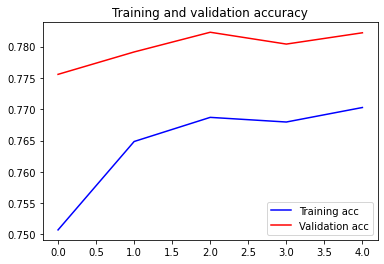

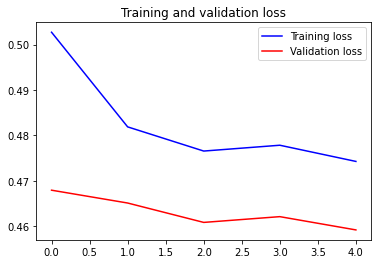

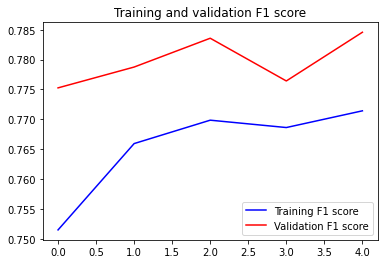

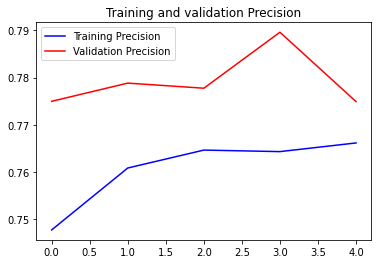

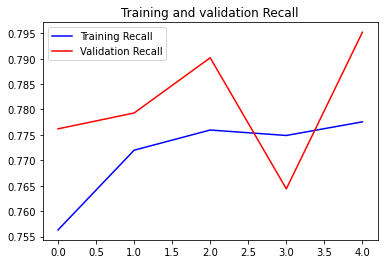

In [34]:
print("LOSS:",score[0])
print("ACCURACY:",score[1])
print("F1 SCORE:",score[2])
print("PRECISION:",score[3])
print("RECALL:",score[4])

#acc = history.history['acc']
#val_acc = history.history['val_acc']
#loss = history.history['loss']
#val_loss = history.history['val_loss']

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
f1 = history['f1_m']
val_f1 = history['val_f1_m']
precision = history['precision_m']
val_precision = history['val_precision_m']
recall = history['recall_m']
val_recall = history['val_recall_m']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
 
plt.plot(epochs, f1, 'b', label='Training F1 score')
plt.plot(epochs, val_f1, 'r', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend()

plt.figure()
 
plt.plot(epochs, precision, 'b', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.figure()
 
plt.plot(epochs, recall, 'b', label='Training Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()
 
plt.show()

In [ ]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    if(score >=0.4 and score<=0.6):
        label = "Neutral"
    if(score <=0.4):
        label = "Negative"
    if(score >=0.6):
        label = "Positive"

    return {"label" : label,
        "score": float(score)}  

In [ ]:
predict("God is good")